Training images shape: (50000, 32, 32, 3)
Training labels shape: (50000,)
Test images shape: (10000, 32, 32, 3)
Test labels shape: (10000,)
Display the first image in the training dataset:


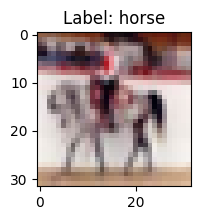

One-hot encoded training labels shape: (50000, 10)
One-hot encoded test labels shape: (10000, 10)
Training images shape after re-sizing: (50000, 64, 64, 3)
Training images min value: 0.0
Training images max value: 1.0
Test images shape after re-sizing: (10000, 64, 64, 3)
Test images min value: 0.0
Test images max value: 1.0


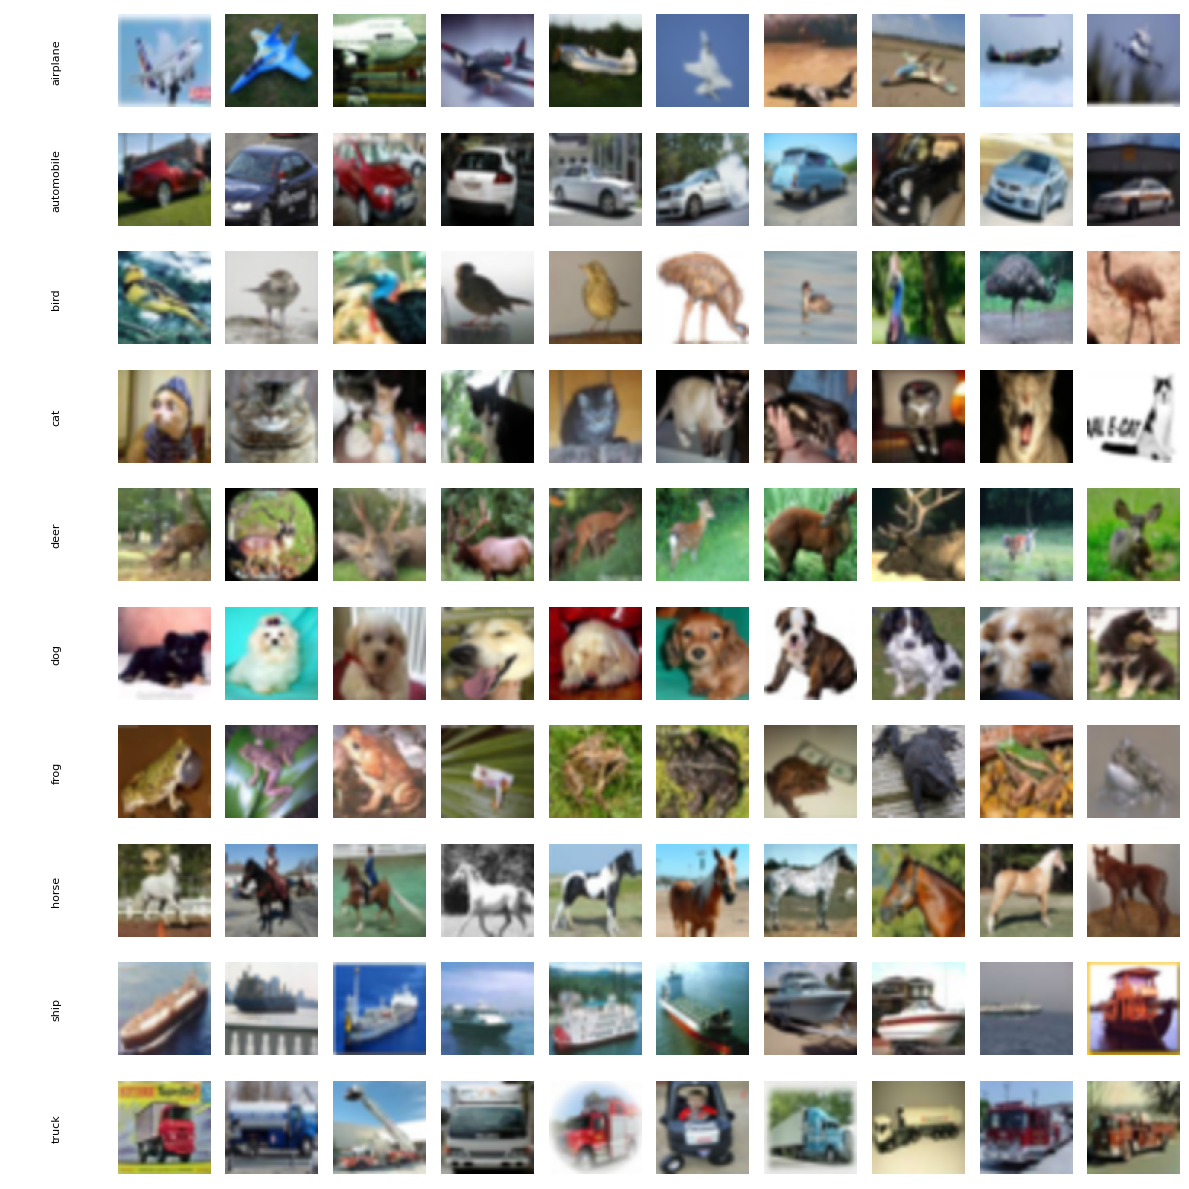

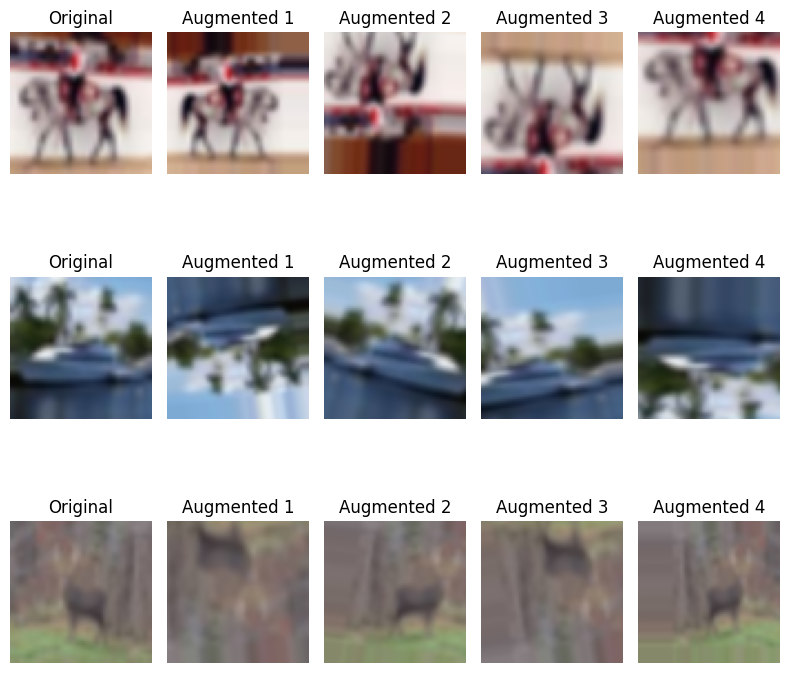

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_90 (Conv2D)                   │ (None, 64, 64, 128)         │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_99               │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_91 (Conv2D)                   │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_100              │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_45 (MaxPooling2D)      │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_61 (Dropout)                 │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_92 (Conv2D)                   │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_101              │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_93 (Conv2D)                   │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_102              │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_46 (MaxPooling2D)      │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_62 (Dropout)                 │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_94 (Conv2D)                   │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_103              │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_95 (Conv2D)                   │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_104              │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_47 (MaxPooling2D)      │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_63 (Dropout)                 │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 9,867,530 (37.64 MB)

 Trainable params: 9,861,130 (37.62 MB)

 Non-trainable params: 6,400 (25.00 KB)

Resized training image size for the pretrained ResNet50: (96, 96, 3)
Resized testing image size for the pretrained ResNet50: (96, 96, 3)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 3, 3, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_7           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_67 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,641,930 (94.00 MB)

 Trainable params: 1,054,218 (4.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step
Predictions shape: (10000, 10)
Custom-CNN Model accuracy: 0.9202
Custom-CNN Model precision: 0.9209
Custom-CNN Model recall: 0.9202
Custom-CNN Model F1 score: 0.9200
Custom-CNN Test accuracy: 0.9202


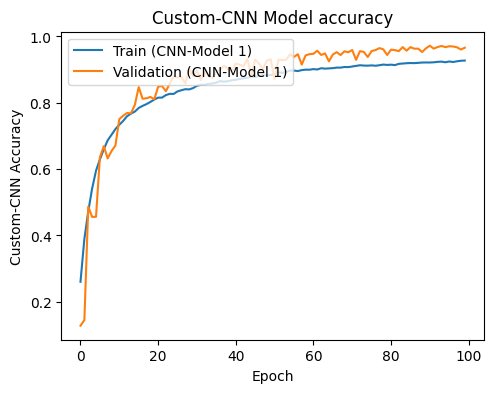

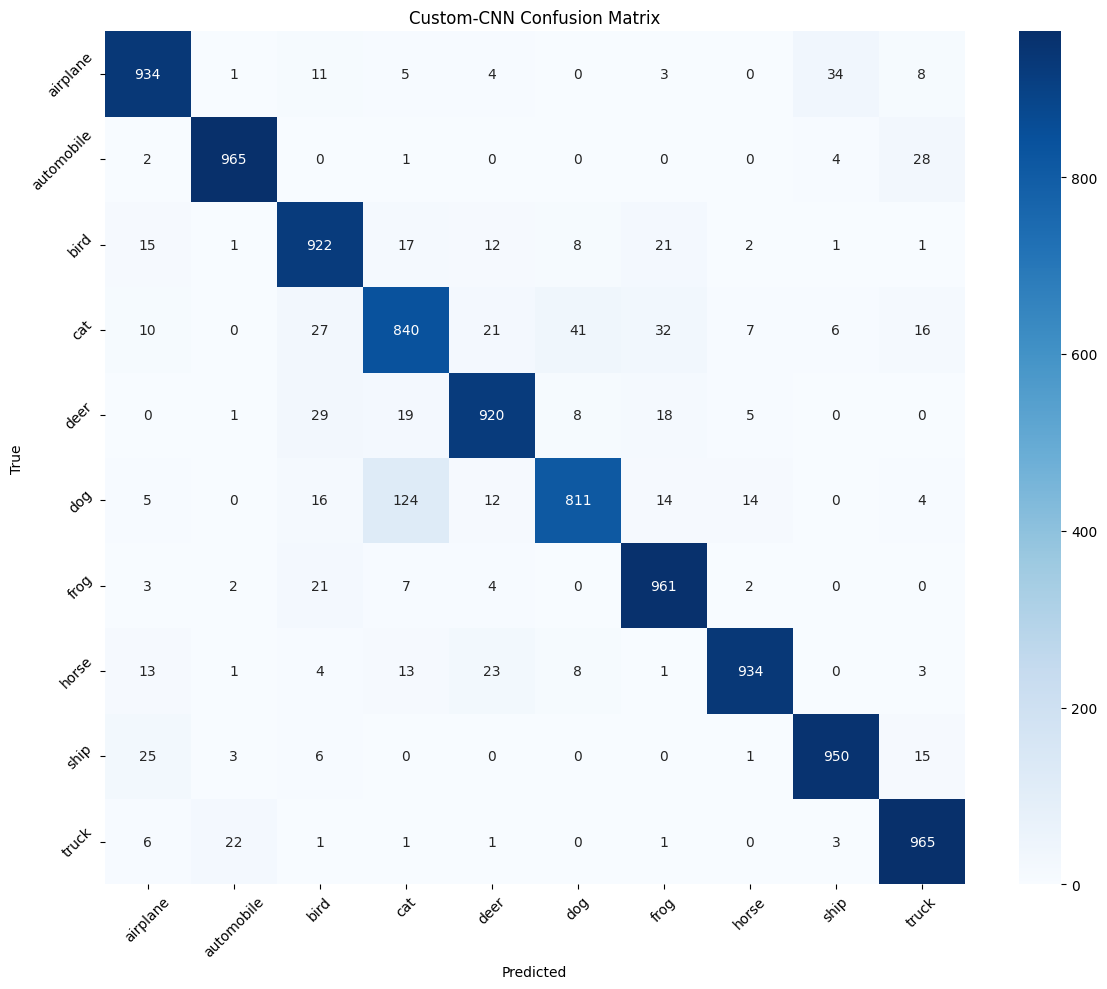

313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.9543 - loss: 0.2656
ResNet50 test data loss: 0.2718542814254761
ResNet50 test data accuracy: 0.9526000022888184
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step
Predictions shape: (10000, 10)
ResNet50 Model accuracy: 0.9526
ResNet50 Model precision: 0.9529
ResNet50 Model recall: 0.9526
ResNet50 Model F1 score: 0.9527


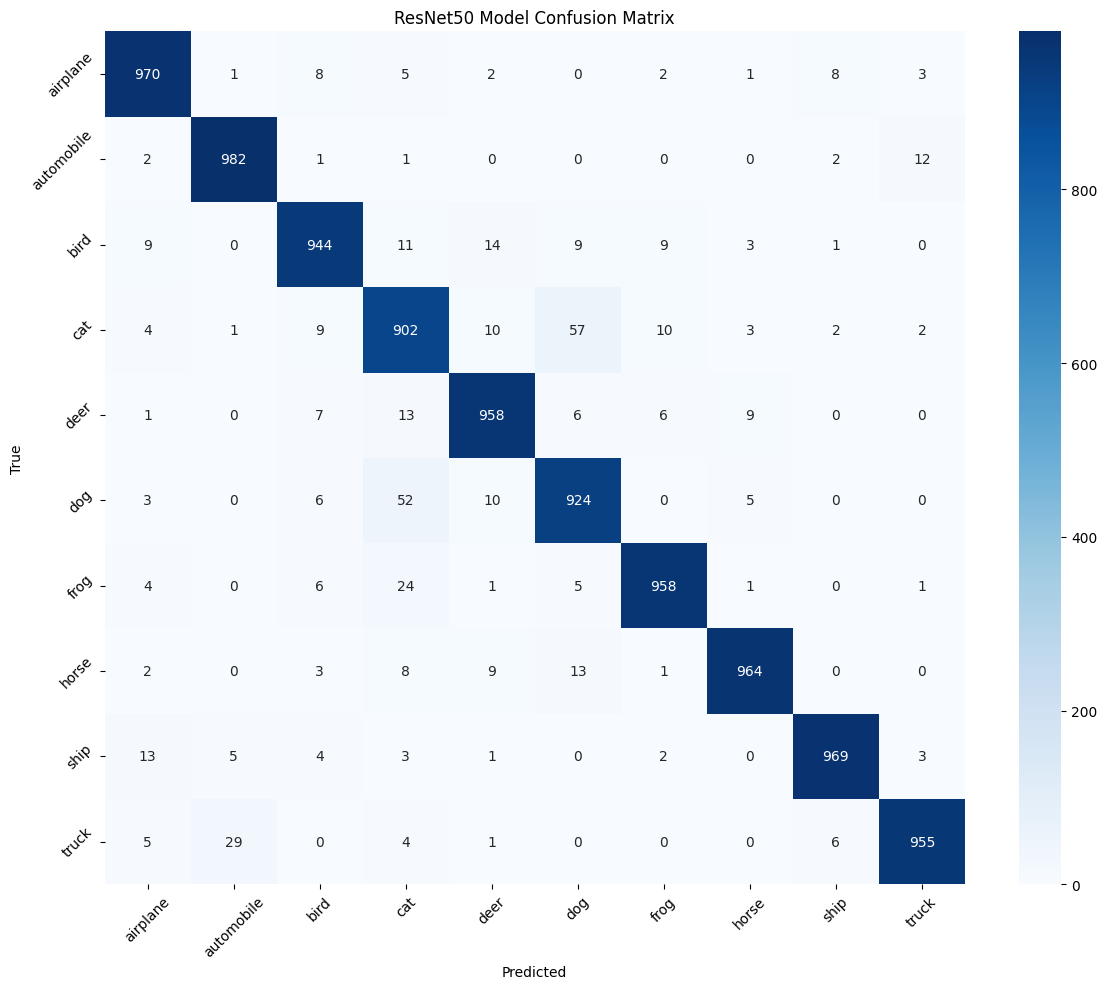

In [15]:
# Import required libraries
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns

# Load and convert the CIFAR-10 dataset to NumPy arrays

# Load the entire dataset at once by setting batch_size=-1
dataset, info = tfds.load('cifar10', with_info=True, batch_size=-1, as_supervised=True)

# Convert the dataset to NumPy arrays
(img_train, label_train), (img_test, label_test) = tfds.as_numpy((dataset['train'], dataset['test']))

# Check the shapes of the arrays to verify the data
print(f"Training images shape: {img_train.shape}")
print(f"Training labels shape: {label_train.shape}")
print(f"Test images shape: {img_test.shape}")
print(f"Test labels shape: {label_test.shape}")

# Define the class labels
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Display the first image in the training dataset
print(f"Display the first image in the training dataset:")
plt.figure(figsize=(2, 2))
plt.imshow(img_train[0])
plt.title(f"Label: {labels[label_train[0]]}")
plt.show()

# 1. Data Preprocessing

# Create one-hot encoded labels
label_train_onehot = to_categorical(label_train, num_classes=10)
label_test_onehot = to_categorical(label_test, num_classes=10)

# Check the shape of the new labels
print(f"One-hot encoded training labels shape: {label_train_onehot.shape}")
print(f"One-hot encoded test labels shape: {label_test_onehot.shape}")

# Normalise the image data
img_train = img_train.astype('float32') / 255.0
img_test = img_test.astype('float32') / 255.0

# Resize the images
img_train = tf.image.resize(img_train, (64, 64))
img_test = tf.image.resize(img_test, (64, 64))

# Convert back to NumPy arrays
img_train = img_train.numpy()
img_test = img_test.numpy()

# Verify the normalization
print(f"Training images shape after re-sizing: {img_train.shape}")
print(f"Training images min value: {img_train.min()}")
print(f"Training images max value: {img_train.max()}")
print(f"Test images shape after re-sizing: {img_test.shape}")
print(f"Test images min value: {img_test.min()}")
print(f"Test images max value: {img_test.max()}")

# Create visualisations of some images and labels
fig, axes = plt.subplots(10, 11, figsize=(12, 12))
classes = np.unique(label_train)
for i, cls in enumerate(classes):
    idxs = np.where(label_train == cls)[0]
    random_idxs = np.random.choice(idxs, 10, replace=False)

    # Add class label to the first column
    axes[i, 0].text(0.5, 0.5, f"{labels[cls]}",
                    ha='center', va='center',
                    rotation=90, fontsize=8)
    axes[i, 0].axis('off')

    # Display images in the remaining columns
    for j, idx in enumerate(random_idxs):
        axes[i, j+1].imshow(img_train[idx])
        axes[i, j+1].axis('off')

plt.tight_layout()
plt.show()

# Split the data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(img_train, label_train_onehot, test_size=0.2, random_state=42)


# Creating data augmentation with the ImageDataGenerator
augment = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    rotation_range=15,
)

# Create a generator for the training data
train_generator = augment.flow(img_train, label_train_onehot, batch_size=256)

# Apply data augmentation to some images and visualise the results
fig, axes = plt.subplots(3, 5, figsize=(8, 8))
for i in range(3):
    orig_image = img_train[i]
    axes[i, 0].imshow(orig_image)
    axes[i, 0].set_title('Original')
    axes[i, 0].axis('off')
    for j in range(1, 5):
        # Apply augmentation to the original image (not normalised)
        augmented_image = augment.random_transform(orig_image)
        axes[i, j].imshow(augmented_image)
        axes[i, j].set_title(f'Augmented {j}')
        axes[i, j].axis('off')
plt.tight_layout()
plt.show()

# 2. Model Architecture

# creating the custom CNN model
model = Sequential([

# First block
Conv2D(128, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 3)),
BatchNormalization(),
Conv2D(128, (3, 3), activation='relu', padding='same'),
BatchNormalization(),
MaxPooling2D((2, 2)),
Dropout(0.2),

# Second block
Conv2D(128, (3, 3), activation='relu', padding='same'),
BatchNormalization(),
Conv2D(128, (3, 3), activation='relu', padding='same'),
BatchNormalization(),
MaxPooling2D((2, 2)),
Dropout(0.3),

# Third block
Conv2D(256, (3, 3), activation='relu', padding='same'),
BatchNormalization(),
Conv2D(256, (3, 3), activation='relu', padding='same'),
BatchNormalization(),
MaxPooling2D((2, 2)),
Dropout(0.4),

# Fourth block
Conv2D(512, (3, 3), activation='relu', padding='same'),
BatchNormalization(),
Conv2D(512, (3, 3), activation='relu', padding='same'),
BatchNormalization(),
MaxPooling2D((2, 2)),
Dropout(0.5),

# Fifth block
Conv2D(512, (3, 3), activation='relu', padding='same'),
BatchNormalization(),
Conv2D(512, (3, 3), activation='relu', padding='same'),
BatchNormalization(),
MaxPooling2D((2, 2)),
Dropout(0.5),

(Flatten()),

Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
BatchNormalization(),
Dropout(0.5),
Dense(10, activation='softmax',kernel_regularizer=tf.keras.regularizers.l2(0.01))
])

model.summary()

# 3. Model Training

# Implement a learning rate schedule to adjust during training
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.9, staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Load the best performing model
loaded_model = load_model('models/custom_cnn_model.keras')

# Compile the model
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Create a validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels)).batch(256)

# Create a ModelCheckpoint callback
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    'models/custom_cnn_model_best.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)
# Train the model
#history = model.fit(train_generator, epochs=100, steps_per_epoch=len(train_images) // 64, validation_data=val_dataset, callbacks=[tf.keras.callbacks.EarlyStopping(patience=10), checkpoint_callback])

# Save the model
#model.save('custom_cnn_model.keras')

# Save the training history
#import pickle
#with open('training_history.pkl', 'wb') as file:
#    pickle.dump(history.history, file)

# Load the training history
import pickle
with open('models/training_history.pkl', 'rb') as file:
    history = pickle.load(file)

# 5. Transfer Learning

# Resizing images

x_train = tf.image.resize(img_train, (96, 96))
x_test = tf.image.resize(img_test, (96, 96))

print('Resized training image size for the pretrained ResNet50:', x_train[0].shape)
print('Resized testing image size for the pretrained ResNet50:', x_test[0].shape)

# Creating the validation set
x_train = np.array(x_train)
y_train = np.array(label_train_onehot)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state = 42)

# Augmenting the data

augment = ImageDataGenerator(
    horizontal_flip = True,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    # rotation_range = 10,      # Most images in the dataset have a natural, upright orientation.
    zoom_range = 0.1)

augment.fit(x_train)

# Defining the pretrained ResNet50 model
base_model = ResNet50(include_top = False, input_shape = (96, 96, 3), weights='imagenet')

base_model.trainable = False

# for layer in base_model.layers[-30:]:
#     layer.trainable = True

#ResNet50 architecture
model_r50 = Sequential()

model_r50.add(InputLayer(input_shape=(96, 96, 3)))

model_r50.add(base_model)
model_r50.add(GlobalAveragePooling2D())

model_r50.add(Dense(512, activation='relu'))
model_r50.add(Dropout(0.3))

model_r50.add(Dense(10, activation='softmax'))

# Model summary
model_r50.summary()

# Compiling the model

# Early stopping / Learning rate scheduler
stopping = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)
scheduler = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 5)

model_r50 = load_model('models/senimtra_r50_95.keras')

# model.load_weights('weights_cycle_1.weights.h5')

model_r50.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.0001), metrics = ['accuracy'])

# Training the model (done in Colab)

# model.fit(augment.flow(x_train, y_train, batch_size = 64), epochs = 50, validation_data = (x_val, y_val), callbacks = [scheduler, stopping])

# Save the model
#model_r50.save('resnet50_best_model.keras')

# 4. Model Evaluation
# 4.A Evaluate the custom CNN model

# Display training metrics
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Custom-CNN Model accuracy')
plt.ylabel('Custom-CNN Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train (CNN-Model 1)', 'Validation (CNN-Model 1)'], loc='upper left')

# Get the true labels
gt = np.argmax(label_test_onehot, axis=1)
gt_labels = [labels[i] for i in gt]

# Predict the output for the test split
predictions = loaded_model.predict(img_test)
predicted_indices = np.argmax(predictions, axis=1)
predicted_labels = [labels[i] for i in predicted_indices]

# Calculate and print the metrics
accuracy = accuracy_score(gt_labels, predicted_labels)
precision = precision_score(gt_labels, predicted_labels, average='weighted')
recall = recall_score(gt_labels, predicted_labels, average='weighted')
f1 = f1_score(gt_labels, predicted_labels, average='weighted')

print(f"Predictions shape: {predictions.shape}")
print(f"Custom-CNN Model accuracy: {accuracy:.4f}")
print(f"Custom-CNN Model precision: {precision:.4f}")
print(f"Custom-CNN Model recall: {recall:.4f}")
print(f"Custom-CNN Model F1 score: {f1:.4f}")

# Calculate accuracy score on the test dataset
accuracy = accuracy_score(gt_labels, predicted_labels)
print(f"Custom-CNN Test accuracy: {accuracy:.4f}")

# Create a confusion matrix
cm = confusion_matrix(gt_labels, predicted_labels, labels=labels)

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Custom-CNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

# 4.B Evaluate the ResNet50 model

# Evaluating the model on the test data
y_test = label_test_onehot
test_loss, test_accuracy = model_r50.evaluate(x_test, y_test)

print('ResNet50 test data loss:', test_loss)
print('ResNet50 test data accuracy:', test_accuracy)

# Predict the output for the test split
predictions_r50 = model_r50.predict(x_test)
predicted_indices_r50 = np.argmax(predictions_r50, axis=1)
predicted_labels_r50 = [labels[i] for i in predicted_indices_r50]

# Calculate and print the metrics
accuracy = accuracy_score(gt_labels, predicted_labels_r50)
precision = precision_score(gt_labels, predicted_labels_r50, average='weighted')
recall = recall_score(gt_labels, predicted_labels_r50, average='weighted')
f1 = f1_score(gt_labels, predicted_labels_r50, average='weighted')

print(f"Predictions shape: {predictions_r50.shape}")
print(f"ResNet50 Model accuracy: {accuracy:.4f}")
print(f"ResNet50 Model precision: {precision:.4f}")
print(f"ResNet50 Model recall: {recall:.4f}")
print(f"ResNet50 Model F1 score: {f1:.4f}")

# Visualising the ResNet50 confusion matrix

# Create a confusion matrix
cm = confusion_matrix(gt_labels, predicted_labels_r50, labels=labels)

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('ResNet50 Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()
